In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from loguru import logger
from math import floor
import datetime 
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_data():
    """Unpack data"""
    stock = pd.read_csv("data/stock_data.csv")[["date", "ticker", "open" , "high", "low", "close"]]
    stock["date"] = pd.to_datetime(stock["date"])
    tickers = pd.read_csv("data/ticker_info.csv", index_col= 0)
    return stock, tickers

In [3]:
class Position:
    """
    Class of position
    ------------------
    params:
    price: float
        Price on which active was bought
    deal_type: str
        Long or Short
    date: str
        Date of deal
    number_of_stocks: int
        Number of stocks bought in this position
    """

    def __init__(self, price: float, deal_type: str, date: str, number_of_stocks: int):
        self.price = price
        self.deal_type = deal_type
        self.date = date
        self.number_of_stocks = number_of_stocks


class Strategy:
    """
    Class of strategy simulation
    ------------------
    params:
    data: pd.DataFrame
        Data with tikers price timeseries
    ticker_name: str
        Name of tiker from data to simulate
    total_sum: float
        Start sum of money
    percent_of_total_sum_for_deal: float
        Percent of available sum to buy asset
    mfm_bound: float
        Border value of MFM indicator to give a signal. 
        From 0 to 100. The bigger the value - the more signals.
    take_profit_percent: float
        Percent of price change relatively to deal price to close deal with profit
    stop_loss_percent: float
        Percent of price change relatively to deal price to stop losing
    short_deals: bool
        False if you want to turn shorts off
    long_deals: bool
        False if you want to turn longs off
    logging: bool
        True if you want to turn logging on
    base_rate: float
        No-risk year proficiency to estimate the efficiency of the strategy
    """
    def __init__(
        self,
        data: pd.DataFrame,
        ticker_name: str,
        total_sum: float,
        percent_of_total_sum_for_deal: float = 0.1,
        mfm_bound: float = 99,
        take_profit_percent: float = 0.05,
        stop_loss_percent: float = 0.05,
        short_deals=True,
        long_deals=True,
        logging=False,
        # ставка treasury US на 10Y сейчас такова
        # Будем считтаь её за среднеголдовую ставку безриского дохода.
        base_rate=2.654,
    ):

        """Class for using and reearching mfm trading strategy"""
        # данные по конкретному тикеру
        self.data = data[data.ticker == ticker_name].copy()
        self.mfm_bound = mfm_bound
        self.data["mfm"] = np.nan
        self.data["signal"] = np.nan
        self.ticker_name = ticker_name
        self.percent_of_total_sum_for_deal = percent_of_total_sum_for_deal
        self.total_sum = total_sum
        self.start_sum = total_sum
        self.stop_loss_percent = stop_loss_percent
        self.take_profit_percent = take_profit_percent
        self.number_of_long_deals = 0
        self.number_of_short_deals = 0
        # история для построения графиков
        self.long_deals_number_history = []
        self.short_deals_number_history = []
        self.total_sum_history = []
        # сразу считаем все mfm и сигналы
        self._calculate_mfm()
        self._find_buy_add_sell_dates()
        self.positions = []
        self.short_deals = short_deals
        self.long_deals = long_deals
        self.last_price = 0.0
        self.date = self.data.date.to_list()
        self.logging = logging
        self.base_rate = base_rate

    def _calculate_mfm(self) -> None:
        """Calculates mfm indicator for every tick"""
        self.data["mfm"] = (
            (
                (self.data["close"] - self.data["low"])
                - (self.data["high"] - self.data["close"])
            )
            * 100
            / (self.data["high"] - self.data["low"])
        )
        self.data.loc[self.data["mfm"].isna(), "mfm"] = 0.0

    def _find_buy_add_sell_dates(self) -> None:
        """Find all buy and sell dots in timeseries of close rice"""
        data_numpy = self.data.to_numpy()
        low = -self.mfm_bound
        high = self.mfm_bound
        for index in range(2, len(data_numpy)):
            if (
                (data_numpy[index, 6] <= low)
                & (data_numpy[index - 1, 6] > low)
                & (data_numpy[index - 2, 6] > low)
            ):
                data_numpy[index, 7] = "buy"
            elif (
                (data_numpy[index, 6] >= high)
                & (data_numpy[index - 1, 6] < high)
                & (data_numpy[index - 2, 6] < high)
            ):
                data_numpy[index, 7] = "sell"
        self.data = pd.DataFrame(data_numpy, columns=self.data.columns)

    def _close_long_position(self, position, price) -> None:
        """Close long position and recalculate total_sum and number of deals"""
        self.total_sum += position.number_of_stocks * price
        self.number_of_long_deals -= position.number_of_stocks
        self.positions.remove(position)

    def _close_short_position(self, position, price) -> None:
        """Close short position and recalculate total_sum and number of deals"""
        self.total_sum -= position.number_of_stocks * price
        self.number_of_short_deals -= position.number_of_stocks
        self.positions.remove(position)

    def _open_long_position(self, row, number_of_stocks)->None:
        """Open long position"""
        price = row["close"]
        self.last_price = price
        new_long_position = Position(
            price=price,
            deal_type="long",
            date=row["date"],
            number_of_stocks=number_of_stocks,
        )
        self.positions.append(new_long_position)
        self.total_sum -= price * number_of_stocks
        self.number_of_long_deals += number_of_stocks

    def _open_short_position(self, row, number_of_stocks)->None:
        """Open short position"""
        price = row["close"]
        new_short_position = Position(
            price=price,
            deal_type="short",
            date=row["date"],
            number_of_stocks=number_of_stocks,
        )
        self.positions.append(new_short_position)
        self.total_sum += price * number_of_stocks
        self.number_of_short_deals += number_of_stocks

    def plot_results(self)->None:
        """Plot signals and price, history of sum 
        and number of deals and calculate metrics"""
        self._count_metrics()
        fig, ax = plt.subplots(4, 1, figsize=(15, 8), dpi=100)
        data_with_signals = self.data[~self.data["signal"].isna()].to_dict(
            orient="records"
        )
        for row in data_with_signals:
            if row["signal"] == "buy":
                ax[0].plot(row["date"], row["close"], "ro", color="green")
            elif row["signal"] == "sell":
                ax[0].plot(row["date"], row["close"], "ro", color="red")
        ax[0].plot(self.data["date"], self.data["close"], color="black")
        ax[0].set_xlabel("date")
        ax[0].set_ylabel("close")
        ax[0].set_title(f"Buy and sell dots of {self.ticker_name} ticker")

        ax[1].plot(self.date, self.total_sum_history)
        ax[2].plot(self.date, self.long_deals_number_history)
        ax[3].plot(self.date, self.short_deals_number_history)
        for i in [0, 1, 2, 3]:
            ax[i].set_xlabel("time")
            ax[i].grid(True)
        ax[1].set_title(f"Total sum of {self.ticker_name}")
        ax[2].set_title(f"Number of long deals of {self.ticker_name}")
        ax[3].set_title(f"Number of short deals of {self.ticker_name}")
        fig.tight_layout()
        plt.show()

    def _close_last_positions(self, last_price)->None:
        """Close all positions on the last tick of timeseries"""
        for position in self.positions:
            if position.deal_type == "short":
                self._close_short_position(position, last_price)
            elif position.deal_type == "long":
                self._close_long_position(position, last_price)

    def _update_histories(self)->None:
        """Add fresh values after each tik"""
        self.long_deals_number_history.append(self.number_of_long_deals)
        self.short_deals_number_history.append(self.number_of_short_deals)
        self.total_sum_history.append(self.total_sum)

    def _count_sharp_ratio(self, average_yeay_to_year_totals)->None:
        """Prints Sharp ratio of strategy"""
        risk_profit_mean = np.array(
            [x - self.base_rate / 100 for x in average_yeay_to_year_totals]
        ).mean()
        risk_profit_std = np.array(average_yeay_to_year_totals).std()
        print(f"Sharp ratio: {round(risk_profit_mean/risk_profit_std, 3)}")

    def _count_profit_to_drawdown(self)->None:
        """Counts portfolio profit to max drawdown"""
        total_profit_div_max_drowdown = (self.total_sum - self.start_sum) / (
            self.start_sum - np.array(self.total_sum_history).min()
        )
        print(
            f"Ratio of final total to max drowdown: {round(total_profit_div_max_drowdown, 3)}"
        )

    def _count_metrics(self)->None:
        """Print Sharp and drawdown"""
        year_to_year_total_sums = []
        for row in zip(self.date, self.total_sum_history):
            # отбираем даты в конце месяца, чтобы посчитать по ним среднегодовую доходность стратегии
            if row[0].day == 31 and row[0].month == 12:
                year_to_year_total_sums.append(row)
        average_yeay_to_year_totals = []
        for i in range(1, len(year_to_year_total_sums)):
            average_yeay_to_year_totals.append(
                year_to_year_total_sums[i][1] / year_to_year_total_sums[i - 1][1] - 1
            )
        self._count_sharp_ratio(average_yeay_to_year_totals)
        self._count_profit_to_drawdown()

    def run_strategy(self) -> None:
        """Iterates through data and simulates strategy"""
        for index, row in self.data.iterrows():
            # print(len(self.positions))
            # за цену в конкретную дату берем
            price = row["close"]
            self.last_price = price
            date = str(row["date"])[:11]
            # смотрим все позиции и смотрим, какие хотим закрыть
            for position in self.positions:
                if position.deal_type == "long":
                    if price / position.price >= 1 + self.take_profit_percent:
                        if self.logging:
                            logger.info(f"Profit long position on {date}")
                        self._close_long_position(position, price)
                    elif price / position.price <= 1 - self.take_profit_percent:
                        if self.logging:
                            logger.info(f"Loss long position on {date}")
                        self._close_long_position(position, price)
                elif position.deal_type == "short":
                    if price / position.price <= 1 - self.stop_loss_percent:
                        if self.logging:
                            logger.info(f"Profit short position on {date}")
                        self._close_short_position(position, price)
                    elif price / position.price >= 1 + self.stop_loss_percent:
                        if self.logging:
                            logger.info(f"Loss short position on {date}")
                        self._close_short_position(position, price)
            # сколько хотим купить? За сделку покупаем по нижней границе от percent_of_total_sum_for_deal
            number_of_stocks = floor(
                self.total_sum * self.percent_of_total_sum_for_deal / price
            )
            if number_of_stocks >= 1:
                # открываем новые, если есть идикаторы и сумма
                if row["signal"] == "buy" and self.long_deals:
                    self._open_long_position(row, number_of_stocks)
                elif row["signal"] == "sell" and self.short_deals:
                    self._open_short_position(row, number_of_stocks)
            else:
                if self.logging:
                    logger.info("No money to make a deal!")
            self._update_histories()
        self._close_last_positions(self.last_price)
        self._update_histories()
        # добавим следующую дату, чтобы были соразмерные массивы
        self.date.append(max(self.date) + datetime.timedelta(days=1))
        self.plot_results()


In [4]:
stock, tickers = get_data()

Sharp ratio: 0.377
Ratio of final total to max drowdown: 1.21


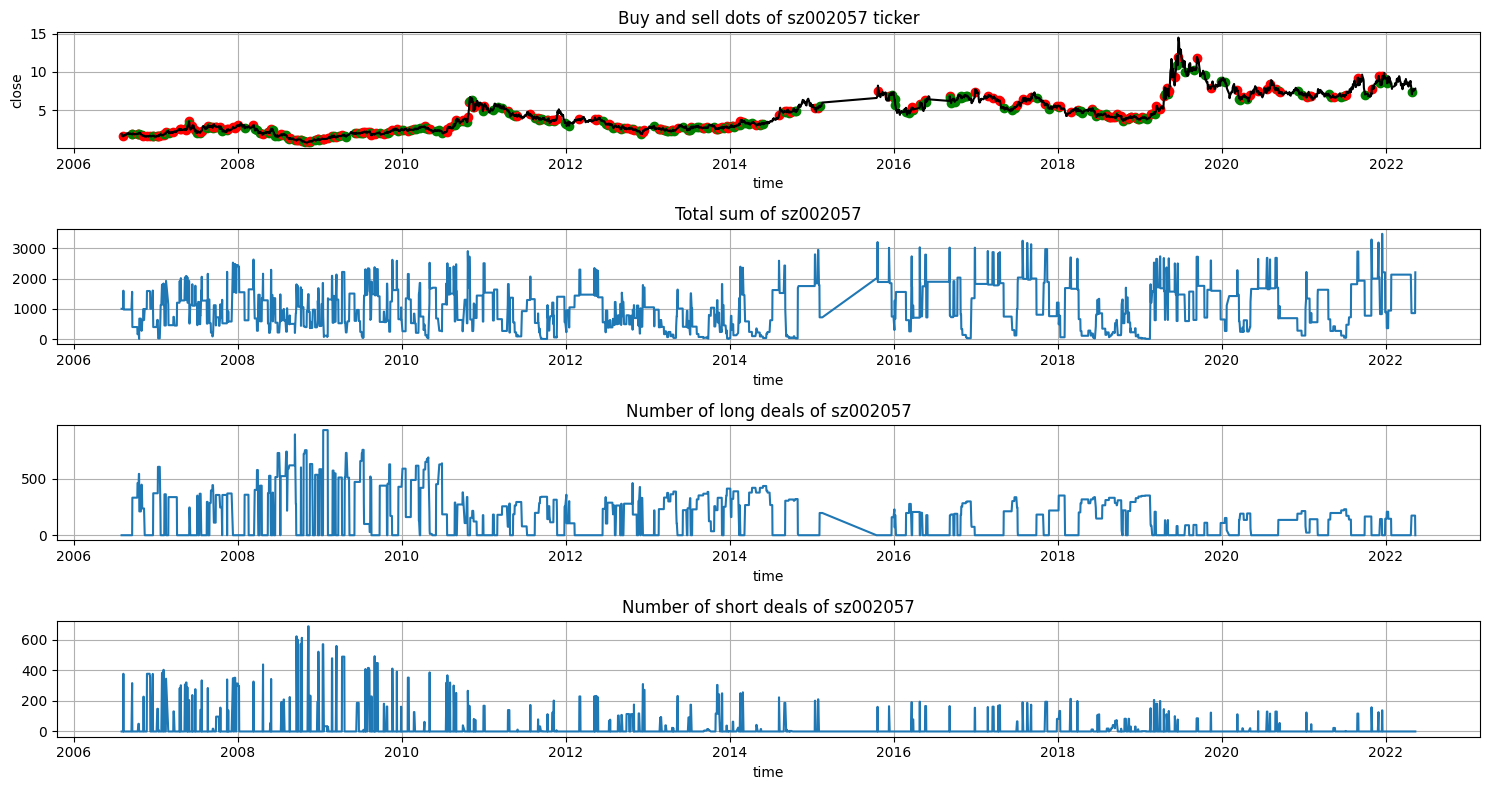

In [5]:
# ticker_name = list(stock.ticker.sample(1).items())[0][1] #случайный тикер
ticker_name = "sz002057"
strategy = Strategy(
    data = stock,
    ticker_name = ticker_name,
    total_sum = 1000.0,
    take_profit_percent = 0.1,
    stop_loss_percent = 0.02,
    percent_of_total_sum_for_deal = 0.6,
    mfm_bound = 100,
    long_deals = True,
    short_deals = True
    )
strategy.run_strategy()